<a href="https://colab.research.google.com/github/Dazzyayan/mlds-research-project/blob/main/ts2vec_attempt_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount google drive mlds_research_project folder
!pip install ruptures
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the desired folder (replace 'mlds_research_project' with your actual folder name)
import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Add the specific directory to the Python path
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
from ts2vec import TS2Vec
import datautils
import torch
print(torch.cuda.is_available())

True


In [3]:

import torch.nn.functional as F

def maxpool(poold):
  output = F.max_pool1d(poold.transpose(1, 2),
              kernel_size = (1 << (p + 1)) + 1,
              stride = 1,
              padding = 1 << p
              ).transpose(1, 2)
  return output

In [4]:
# @title Default title text
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from ts2vec import TS2Vec
import ruptures as rpt
from scipy.signal import find_peaks, correlate
import torch
import torch.nn.functional as F

def train_ts2vec_model(train_data, input_dims=1, output_dims=320, device=0):
    """
    Trains a TS2Vec model on the provided training data.

    Args:
        train_data (np.ndarray): Training data (n_instances, n_timestamps, n_features).
        input_dims (int): Input dimensions for TS2Vec model.
        output_dims (int): Output dimensions for TS2Vec representations.
        device (int): Device to use for training (0 for GPU, -1 for CPU).

    Returns:
        TS2Vec: The trained TS2Vec model.
    """
    print("Training TS2Vec model...")
    model = TS2Vec(
        input_dims=input_dims,
        device=device,
        output_dims=output_dims
    )
    loss_log = model.fit(
        train_data,
        verbose=False
    )
    print("TS2Vec model training complete.")
    return model

In [5]:
# Assuming /content/drive/MyDrive/mlds_research_project is in your Python path
from sim_gen import milestone_2_sim
import numpy as np

# Initialize empty lists to store data and changepoints
synthetic_data = []
synthetic_cps = []

# Loop 100 times to generate data
for _ in range(1000):
    # Generate a single instance of data and its changepoints
    # data, cps, _ = milestone_2_sim.generate_changepoint_data(M=5)
    data, cps, _ = milestone_2_sim.generate_changepoint_ar_data(M=5)

    # Reshape the data if it's 1D to ensure a feature dimension
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Append the generated data and changepoints to the lists
    synthetic_data.append(data)
    synthetic_cps.append(cps)

# Note: The generated time series instances might have different lengths.
# Further processing will be needed to handle variable lengths,
# for example, by padding or truncation before using them in TS2Vec.
# For now, we just store them as a list of arrays.
# Determine the maximum length among the generated time series
max_len = max(data.shape[0] for data in synthetic_data)

# Pad the synthetic data instances to the maximum length
padded_synthetic_data = []
for data in synthetic_data:
    padding_length = max_len - data.shape[0]
    # Pad with zeros at the end along the time dimension (axis=0)
    padded_data = np.pad(data, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
    padded_synthetic_data.append(padded_data)

# Convert the list of padded arrays into a single NumPy array
train_data_gen = np.stack(padded_synthetic_data, axis=0)

# For simplicity in this analysis, we will use the same padded data for testing
test_data_gen = np.stack(padded_synthetic_data, axis=0)

# Create dummy labels for the 100 instances (e.g., all zeros)
# The actual labels are not directly used in the TS2Vec analysis for changepoint detection,
# but a label array is required by the analyze_ts2vec_with_peak_finding function signature.
train_labels_gen = np.zeros(len(synthetic_data))
test_labels_gen = np.zeros(len(synthetic_data))

# Prepare the ground truth changepoints in a format expected by the analysis function
# The analyze function expects a list of lists, where each inner list contains the changepoints for an instance.
ground_truth_cps_gen = synthetic_cps

print(f"Shape of generated and padded training data: {train_data_gen.shape}")
print(f"Shape of generated and padded testing data: {test_data_gen.shape}")
print(f"Number of ground truth changepoint lists: {len(ground_truth_cps_gen)}")

Shape of generated and padded training data: (1000, 903, 1)
Shape of generated and padded testing data: (1000, 903, 1)
Number of ground truth changepoint lists: 1000


In [6]:
# Train the TS2Vec model
trained_model = train_ts2vec_model(
    train_data=train_data_gen,
    input_dims=train_data_gen.shape[-1], # Use the actual input dimensions from the data
    device=0 # Specify device if needed
)


Training TS2Vec model...
TS2Vec model training complete.


In [10]:
import numpy as np

# Define a simple rectangular kernel
kernel_size = 11 # Example kernel size
rectangular_kernel = np.ones(kernel_size)

# Normalize the kernel
rectangular_kernel = rectangular_kernel / np.sum(rectangular_kernel)

print("Generated Rectangular Kernel:")
display(rectangular_kernel)

def evaluate_changepoint_detection(ground_truth_cps, detected_cps, tolerance=5):
    """
    Evaluates changepoint detection performance for a single instance.

    Args:
        ground_truth_cps (list): List of ground truth changepoint timestamps.
        detected_cps (list): List of detected changepoint timestamps.
        tolerance (int): The tolerance window around ground truth changepoints
                         to consider a detected changepoint a True Positive.

    Returns:
        tuple: (tp, fp, fn, precision, recall, f1_score)
               tp (int): True Positives
               fp (int): False Positives
               fn (int): False Negatives
               precision (float): Precision score
               recall (float): Recall score
               f1_score (float): F1-score
    """
    tp = 0
    fp = 0
    fn = 0

    # Create a boolean array to track if a ground truth CP has been matched
    matched_gt = [False] * len(ground_truth_cps)

    # Count True Positives and False Positives
    for detected_cp in detected_cps:
        is_tp = False
        for i, gt_cp in enumerate(ground_truth_cps):
            if abs(detected_cp - gt_cp) <= tolerance and not matched_gt[i]:
                tp += 1
                matched_gt[i] = True
                is_tp = True
                break # Move to the next detected CP once a match is found
        if not is_tp:
            fp += 1

    # Count False Negatives (ground truth CPs that were not matched)
    fn = len(ground_truth_cps) - sum(matched_gt)

    # Calculate Precision, Recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return tp, fp, fn, precision, recall, f1_score

Generated Rectangular Kernel:


array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks, convolve
import ruptures as rpt # Assuming ruptures is installed for PELT

def generate_ts2vec_representations_component(model, data, sliding_length, sliding_padding):
    """
    Generates TS2Vec representations for the input data using the provided model.

    Args:
        model (TS2Vec): The trained TS2Vec model.
        data (np.ndarray): Input data (n_instances, n_timestamps, n_features).
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int): Sliding window padding for encoding.

    Returns:
        np.ndarray: TS2Vec representations (n_instances, n_timestamps, output_dims).
    """
    print("Generating sliding window representations...")
    representations = model.encode(
        data,
        causal=True,
        sliding_length=sliding_length,
        sliding_padding=sliding_padding
    )
    print(f'Shape of representations: {representations.shape}')
    print("Representation generation complete.")
    return representations

def calculate_similarity_vs_maxpool_component(latest_repr, lookback_reprs, local_window_size):
    """
    Calculates the cosine similarity between a local window representation (maxpooled latest + local_window_size previous)
    and the maxpooled representation of the lookback window since the last changepoint.

    Args:
        latest_repr (np.ndarray): Representation of the latest timestamp (1, output_dims).
        lookback_reprs (np.ndarray): Representations of the lookback window since the last changepoint (window_size, output_dims).
        local_window_size (int): The number of previous timestamps to include in the local window for maxpooling (including the latest).

    Returns:
        float: Cosine similarity.
    """
    # Combine latest representation with previous local_window_size - 1 representations
    # Need access to the representations *before* the current timestamp for the local window.
    # This function signature needs to be adjusted to receive the necessary representations.
    # For now, let's assume 'latest_repr' actually contains the representations for the local window.
    # A better approach is to pass a slice of representations for the local window.

    # Let's modify the function to accept the representations for the local window directly.
    # The calling function (run_changepoint_analysis_componentized) will need to provide this slice.

    # New signature: calculate_similarity_vs_maxpool_component(local_window_reprs, segment_reprs)

    # Placeholder logic based on the new understanding:
    # This component will now take the representations of the local window and the segment.

    # Refactoring Note: The name should probably change to reflect the new comparison.
    # Maybe calculate_local_window_vs_segment_similarity_component

    # Let's revert the change here and think about how to structure this in the main loop.
    # The local window needs representations from t - local_window_size + 1 to t.
    # The segment needs representations from last_cp_index to t.

    # It's better to keep the similarity calculation focused and handle the data slicing in the main loop.
    # Let's add a new component or modify the main loop to create the local window representation.

    # Reverting to the previous function logic, but will need to adjust the main loop.
    if lookback_reprs.shape[0] == 0:
        return np.nan # Handle empty lookback window

    # Maxpool the lookback representations (segment since last CP)
    poold_segment = torch.from_numpy(lookback_reprs).unsqueeze(0)
    p_segment = int(np.log2(poold_segment.shape[1] - 1)) if poold_segment.shape[1] > 1 else 0
    maxpooled_segment_repr = F.max_pool1d(poold_segment.transpose(1, 2),
                                         kernel_size=(1 << (p_segment + 1)) + 1,
                                         stride=1,
                                         padding=1 << p_segment
                                        ).transpose(1, 2)
    maxpooled_segment_repr_np = maxpooled_segment_repr.squeeze(0).numpy()
    if maxpooled_segment_repr_np.ndim == 1:
        maxpooled_segment_repr_np = maxpooled_segment_repr_np.reshape(1, -1)

    # The 'latest_repr' input should now represent the local window.
    # Assuming 'latest_repr' is already the maxpooled local window representation.
    # This requires the calling code to prepare this 'local_window_repr'.

    # Calculate cosine similarity between the local window representation and the maxpooled segment representation
    similarity = cosine_similarity(latest_repr, maxpooled_segment_repr_np)[0, 0]
    return similarity


def apply_online_matched_filter_component(segment_signal, kernel):
    """
    Applies a matched filter online to the latest part of the segment signal.

    Args:
        segment_signal (list): List of signal values in the current segment.
        kernel (np.ndarray): The matched filter kernel.

    Returns:
        float: The latest filtered value, or NaN if the segment is too short.
    """
    if kernel is None or len(segment_signal) < len(kernel):
        return np.nan

    # Apply convolution to the recent segment signal values
    convolved_signal = convolve(segment_signal[-len(kernel):], kernel, mode='valid')
    if len(convolved_signal) > 0:
        return convolved_signal[-1]
    else:
        return np.nan


def calculate_online_moving_averages_component(signal, window_size, short_window_size):
    """
    Calculates the moving averages of the signal online.

    Args:
        signal (list): List of signal values in the current segment (or full history).
        window_size (int): The window size for the first moving average.
        short_window_size (int): The window size for the second moving average.

    Returns:
        tuple: (latest_ma, latest_ma_short)
               latest_ma (float): The latest value of the first moving average.
               latest_ma_short (float): The latest value of the second moving average.
    """
    latest_ma = np.nan
    latest_ma_short = np.nan

    if len(signal) >= window_size:
        latest_ma = np.mean(signal[-window_size:])

    if len(signal) >= short_window_size:
         latest_ma_short = np.mean(signal[-short_window_size:])

    return latest_ma, latest_ma_short

def calculate_online_difference_and_stddev_component(signal, moving_average, diff_window_size):
    """
    Calculates the absolute difference between the latest signal value and its moving average,
    and the moving average and standard deviation of the difference signal.

    Args:
        signal (list): List of signal values used for difference calculation (current segment or full history).
        moving_average (float): The latest value of the moving average of the signal.
        diff_window_size (int): The window size for the moving average and std dev of the difference.

    Returns:
        tuple: (latest_difference, latest_ma_difference, latest_std_dev_difference)
               latest_difference (float): The latest absolute difference.
               latest_ma_difference (float): The latest moving average of the difference signal.
               latest_std_dev_difference (float): The latest standard deviation of the difference signal.
    """
    latest_difference = np.nan
    latest_ma_difference = np.nan
    latest_std_dev_difference = np.nan

    if not np.isnan(signal[-1]) and not np.isnan(moving_average):
         latest_difference = np.abs(signal[-1] - moving_average)

    # Calculate moving average and std dev of the difference signal
    # This assumes the difference signal is being accumulated elsewhere and passed implicitly or globally
    # For a componentized approach, it's better to pass the difference signal history
    # Let's assume for now we calculate based on the latest difference and accumulated history (needs refinement)
    # A better approach would be to pass the list of recent differences to this function.
    # For now, let's simplify and return only the latest difference.
    return latest_difference # Simplified return for now


def detect_changepoint_stddev_threshold_component(difference, ma_difference, stddev_difference, threshold_multiplier):
    """
    Detects a changepoint based on a standard deviation threshold.

    Args:
        difference (float): The latest difference value.
        ma_difference (float): The latest moving average of the difference signal.
        stddev_difference (float): The latest standard deviation of the difference signal.
        threshold_multiplier (float): The multiplier for the standard deviation.

    Returns:
        bool: True if a changepoint is detected, False otherwise.
    """
    if not np.isnan(difference) and not np.isnan(ma_difference) and not np.isnan(stddev_difference):
        detection_threshold = ma_difference + threshold_multiplier * stddev_difference
        return difference > detection_threshold
    return False

def reset_online_state_component():
    """
    Resets the state variables for a new segment after a changepoint detection.

    Returns:
        tuple: Reset values for segment-specific lists and other state variables.
    """
    return [], [], [], [], [], [] # Reset segment raw sims, filtered sims, diffs, MAs, etc.


def run_changepoint_analysis_componentized(model, test_data, test_labels, sliding_length=1, sliding_padding=6, num_instances_to_plot=10, moving_average_window=10, pelt_model="rbf", pelt_pen=10, peak_height=None, peak_threshold=None, peak_distance=None, peak_prominence=None, peak_width=None, peak_wlen=None, peak_rel_height=None, ground_truth_cps=None, matched_filter_kernel=None, use_pelt=True, peak_on_difference=True, filter_cosine_similarity=False, lookback_window=10, evaluation_tolerance=5, matched_filter_kernel_size=20, stddev_threshold_multiplier=2, local_window_size=5): # Added local_window_size
    """
    Analyzes TS2Vec representations for changepoint detection using a componentized approach.

    Args:
        model (TS2Vec): The trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray): Test labels.
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int or list): Sliding window padding for encoding. Can be a single value or a list of values.
        num_instances_to_plot (int): Number of test instances to plot.
        moving_average_window (int): Window size for moving average of cosine similarity (or filtered similarity).
        pelt_model (str): The cost function for PELT ('l2', 'l1', 'rbf', 'linear', 'cosine', 'normal', 'ar').
        pelt_pen (float): The penalty value for PELT.
        peak_height (float or array_like or None): Required height of peaks for offline plotting.
        peak_threshold (float or array_like or None): Required threshold of peaks for offline plotting.
        peak_distance (float or array_like or None): Required horizontal distance between neighboring peaks for offline plotting.
        peak_prominence (float or array_like or None): Required prominence of peaks for offline plotting.
        peak_width (float or array_like or None): Required width of peaks for offline plotting.
        peak_wlen (int or None): A window length in samples for offline plotting.
        peak_rel_height (float or None): The relative height for offline plotting.
        ground_truth_cps (list or None): Ground truth changepoint locations.
        matched_filter_kernel (np.ndarray or None): A kernel to apply as a matched filter.
        use_pelt (bool): Whether to apply PELT changepoint detection.
        peak_on_difference (bool): If True, perform offline peak detection on the absolute difference signal.
        filter_cosine_similarity (bool): If True, apply the matched filter to the cosine similarity signal before MA/diff.
        lookback_window (int): The minimum number of previous timestamps required for the maxpooling window (segment since last CP).
        evaluation_tolerance (int): The tolerance window for matching detected changepoints to ground truth.
        matched_filter_kernel_size (int): The size of the rectangular kernel for the matched filter (if kernel not provided).
        stddev_threshold_multiplier (float): The multiplier for the standard deviation in online detection.
        local_window_size (int): The size of the local window for maxpooling with the latest timestamp.

    Returns:
        dict: Evaluation metrics by padding value.
    """
    # Ensure sliding_padding is a list
    if not isinstance(sliding_padding, list):
        sliding_padding_values = [sliding_padding]
    else:
        sliding_padding_values = sliding_padding

    evaluation_metrics_by_padding = {}

    # Validate ground_truth_cps if provided
    if ground_truth_cps is not None and len(ground_truth_cps) != len(test_data):
        print("Warning: Length of ground_truth_cps does not match the number of test instances.")
        ground_truth_cps = None

    # Limit the number of instances to process
    test_data_subset = test_data[:num_instances_to_plot]
    test_labels_subset = test_labels[:num_instances_to_plot]
    ground_truth_cps_subset = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Create the rectangular matched filter kernel if needed
    matched_filter_kernel_to_use = None
    if matched_filter_kernel is not None:
        matched_filter_kernel_to_use = matched_filter_kernel
    elif matched_filter_kernel_size > 0:
        matched_filter_kernel_to_use = np.ones(matched_filter_kernel_size) / matched_filter_kernel_size


    for current_padding in sliding_padding_values:
        print(f"\n--- Analyzing with sliding_padding = {current_padding} ---")

        # Component 1: Generate TS2Vec representations
        test_repr = generate_ts2vec_representations_component(
            model,
            test_data_subset,
            sliding_length,
            current_padding
        )

        n_instances, n_timestamps, _ = test_repr.shape

        print(f"Performing online analysis for {n_instances} instances with sliding_padding = {current_padding}...")

        instance_tp = []
        instance_fp = []
        instance_fn = []
        instance_precision = []
        instance_recall = []
        instance_f1 = []

        for i in range(n_instances):
            instance_repr = test_repr[i, :, :]
            original_data = test_data_subset[i, :, 0]

            # Initialize online processing state
            last_cp_index = 0
            detected_online_cps = []

            # Lists to store full history for plotting and offline analysis
            full_history_cosine_similarities_vs_maxpool = [] # This will now store similarity between local window and segment maxpool
            full_history_filtered_similarity_online = []
            full_history_moving_averages_online = []
            full_history_moving_averages_online_short = []
            full_history_difference_signal_online = []
            full_history_moving_average_difference_online = []
            full_history_std_dev_difference_online = []

            # Lists to store segment data for online calculations
            current_segment_raw_similarities = [] # This list now stores the new similarity values (local vs segment)
            current_segment_filtered_similarities = []
            current_segment_difference_online = []


            # Component 2: Online Processing Loop
            for t in range(n_timestamps):
                # Get the representations for the local window
                local_window_start = max(0, t - local_window_size + 1)
                local_window_reprs = instance_repr[local_window_start:t+1, :] # Include the latest timestamp

                # Get the representations for the segment since the last changepoint
                segment_reprs = instance_repr[last_cp_index:t+1, :] # Include the latest timestamp

                # Check window sizes
                if local_window_reprs.shape[0] < local_window_size or segment_reprs.shape[0] < lookback_window:
                    # Append NaNs for this timestamp if windows are too short
                    full_history_cosine_similarities_vs_maxpool.append(np.nan)
                    full_history_filtered_similarity_online.append(np.nan)
                    full_history_moving_averages_online.append(np.nan)
                    full_history_moving_averages_online_short.append(np.nan)
                    full_history_difference_signal_online.append(np.nan)
                    full_history_moving_average_difference_online.append(np.nan)
                    full_history_std_dev_difference_online.append(np.nan)
                    current_segment_raw_similarities.append(np.nan)
                    current_segment_filtered_similarities.append(np.nan)
                    current_segment_difference_online.append(np.nan)
                    continue

                # Create local window representation by maxpooling
                poold_local = torch.from_numpy(local_window_reprs).unsqueeze(0)
                p_local = int(np.log2(poold_local.shape[1] - 1)) if poold_local.shape[1] > 1 else 0
                maxpooled_local_repr = F.max_pool1d(poold_local.transpose(1, 2),
                                                 kernel_size=(1 << (p_local + 1)) + 1,
                                                 stride=1,
                                                 padding=1 << p_local
                                                ).transpose(1, 2)
                maxpooled_local_repr_np = maxpooled_local_repr.squeeze(0).numpy()
                if maxpooled_local_repr_np.ndim == 1:
                    maxpooled_local_repr_np = maxpooled_local_repr_np.reshape(1, -1)


                # Component 3: Calculate similarity (local window vs segment maxpool)
                # Pass the maxpooled local window representation and the segment representations
                similarity = calculate_similarity_vs_maxpool_component(maxpooled_local_repr_np, segment_reprs, lookback_window) # lookback_window is not used in the modified component, can remove
                full_history_cosine_similarities_vs_maxpool.append(similarity)
                current_segment_raw_similarities.append(similarity)


                # Component 4: Apply online matched filter
                filtered_sim = apply_online_matched_filter_component(current_segment_raw_similarities, matched_filter_kernel_to_use)
                full_history_filtered_similarity_online.append(filtered_sim)
                current_segment_filtered_similarities.append(filtered_sim)

                # Determine which signal to use for MA and difference calculation
                signal_for_ma_diff = current_segment_filtered_similarities if filter_cosine_similarity else current_segment_raw_similarities
                valid_signal_for_ma_diff = [val for val in signal_for_ma_diff if not np.isnan(val)]


                # Component 5: Calculate online moving averages
                latest_ma, latest_ma_short = calculate_online_moving_averages_component(
                    valid_signal_for_ma_diff,
                    moving_average_window,
                    max(1, moving_average_window // 2)
                )
                full_history_moving_averages_online.append(latest_ma)
                full_history_moving_averages_online_short.append(latest_ma_short)

                # Component 6: Calculate online difference and its MA/StdDev
                latest_value_for_diff = valid_signal_for_ma_diff[-1] if len(valid_signal_for_ma_diff) > 0 else np.nan
                latest_difference = np.abs(latest_value_for_diff - latest_ma) if not np.isnan(latest_value_for_diff) and not np.isnan(latest_ma) else np.nan

                full_history_difference_signal_online.append(latest_difference)
                current_segment_difference_online.append(latest_difference)

                valid_current_difference_window = [diff for diff in current_segment_difference_online if not np.isnan(diff)]

                latest_ma_difference = np.nan
                latest_std_dev_difference = np.nan

                if len(valid_current_difference_window) >= moving_average_window:
                     latest_ma_difference = np.mean(valid_current_difference_window[-moving_average_window:])
                     latest_std_dev_difference = np.std(valid_current_difference_window[-moving_average_window:])

                full_history_moving_average_difference_online.append(latest_ma_difference)
                full_history_std_dev_difference_online.append(latest_std_dev_difference)


                # Component 7: Online changepoint detection
                changepoint_detected = detect_changepoint_stddev_threshold_component(
                    latest_difference,
                    latest_ma_difference,
                    latest_std_dev_difference,
                    stddev_threshold_multiplier
                )

                if changepoint_detected:
                    detected_online_cps.append(t)
                    print(f"Changepoint detected at timestamp {t} for instance {i+1}")
                    # Component 8: Reset online state
                    last_cp_index = t
                    current_segment_raw_similarities, current_segment_filtered_similarities, current_segment_difference_online = reset_online_state_component()[:3]

            # Convert full history lists to numpy arrays for plotting
            full_history_cosine_similarities_vs_maxpool = np.array(full_history_cosine_similarities_vs_maxpool)
            full_history_filtered_similarity_online = np.array(full_history_filtered_similarity_online)
            full_history_moving_averages_online = np.array(full_history_moving_averages_online)
            full_history_moving_averages_online_short = np.array(full_history_moving_averages_online_short)
            full_history_difference_signal_online = np.array(full_history_difference_signal_online)
            full_history_moving_average_difference_online = np.array(full_history_moving_average_difference_online)
            full_history_std_dev_difference_online = np.array(full_history_std_dev_difference_online)


            # Component 9: Offline Peak Finding (for plotting if needed)
            signal_for_offline_peaks = None
            peak_x_offset = 0
            if peak_on_difference and len(full_history_difference_signal_online) > 0 and not np.all(np.isnan(full_history_difference_signal_online)):
                 signal_for_offline_peaks = full_history_difference_signal_online
                 peak_x_offset = np.where(~np.isnan(signal_for_offline_peaks))[0][0] if np.where(~np.isnan(signal_for_offline_peaks))[0].size > 0 else 0
            elif not peak_on_difference and len(full_history_cosine_similarities_vs_maxpool) > 0 and not np.all(np.isnan(full_history_cosine_similarities_vs_maxpool)):
                 signal_for_offline_peaks = full_history_cosine_similarities_vs_maxpool
                 peak_x_offset = np.where(~np.isnan(signal_for_offline_peaks))[0][0] if np.where(~np.isnan(signal_for_offline_peaks))[0].size > 0 else 0


            peaks = []
            if signal_for_offline_peaks is not None and len(signal_for_offline_peaks) > 0 and not np.all(np.isnan(signal_for_offline_peaks)):
                 try:
                     valid_signal_for_offline_peaks = signal_for_offline_peaks[~np.isnan(signal_for_offline_peaks)]
                     peaks, _ = find_peaks(
                         valid_signal_for_offline_peaks,
                         height=peak_height,
                         threshold=peak_threshold,
                         distance=peak_distance,
                         prominence=peak_prominence,
                         width=peak_width,
                         wlen=peak_wlen,
                         rel_height=peak_rel_height
                     )
                 except ValueError as e:
                     print(f"Warning: Could not perform offline peak finding for instance {i+1}: {e}")
                     peaks = []
            else:
                print(f"Warning: Signal for offline peak finding is empty or all NaN for instance {i+1}. Skipping peak detection.")


            # Component 10: Plotting results
            fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

            axes[0].plot(original_data)
            axes[0].set_title(f'Original Time Series for Instance {i+1} (Label: {test_labels_subset[i]}) - Padding: {current_padding}')
            axes[0].set_ylabel('Value')
            axes[0].grid(True)

            pelt_results = []
            if use_pelt:
                signal_flat = original_data.flatten()
                try:
                    algo = rpt.Pelt(model=pelt_model).fit(signal_flat)
                    pelt_results = algo.predict(pen=pelt_pen)
                except Exception as e:
                     print(f"Warning: Could not perform PELT detection for instance {i+1}: {e}")
                     pelt_results = []


                for cp in pelt_results:
                    if cp < n_timestamps:
                        axes[0].axvline(x=cp, color='red', linestyle='--', lw=1.5, label='PELT Changepoint' if cp == pelt_results[0] else "")

            if ground_truth_cps_subset is not None and i < len(ground_truth_cps_subset):
                 for gt_cp in ground_truth_cps_subset[i]:
                      if gt_cp < n_timestamps:
                           axes[0].axvline(x=gt_cp, color='green', linestyle='-', lw=1.5, label='Ground Truth Changepoint' if gt_cp == ground_truth_cps_subset[i][0] else "")

            for online_cp in detected_online_cps:
                 if online_cp < n_timestamps:
                      axes[0].axvline(x=online_cp, color='orange', linestyle='--', lw=1.5, label='Detected Online CP' if online_cp == detected_online_cps[0] else "")

            handles, labels = axes[0].get_legend_handles_labels()
            unique_labels = {}
            for handle, label in zip(handles, labels):
                 unique_labels[label] = handle
            axes[0].legend(unique_labels.values(), unique_labels.keys())


            # Plotting Cosine Similarity and Moving Average (using full history)
            timestamps_full = np.arange(n_timestamps)

            if len(full_history_cosine_similarities_vs_maxpool) == n_timestamps:
                 axes[1].plot(timestamps_full, full_history_cosine_similarities_vs_maxpool, label='Local Window vs Segment Maxpool (Unfiltered)') # Updated label

            if len(full_history_filtered_similarity_online) == n_timestamps:
                 axes[1].plot(timestamps_full, full_history_filtered_similarity_online, label='Local Window vs Segment Maxpool (Filtered)', color='green') # Updated label

            if len(full_history_moving_averages_online) == n_timestamps:
                 axes[1].plot(timestamps_full, full_history_moving_averages_online, label=f'Moving Average (window={moving_average_window})', color='red')

            if len(full_history_moving_averages_online_short) == n_timestamps:
                 axes[1].plot(timestamps_full, full_history_moving_averages_online_short, label=f'Moving Average (window={max(1, moving_average_window // 2)})', color='purple', linestyle=':')


            axes[1].set_title(f'Cosine Similarity and Moving Average - Padding: {current_padding}') # Title might need adjustment
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].legend()
            axes[1].grid(True)
            axes[1].set_xlim(0, n_timestamps - 1)


            # Plot the signal used for peak finding (using full history)
            if peak_on_difference and len(full_history_difference_signal_online) == n_timestamps:
                 axes[2].plot(timestamps_full, full_history_difference_signal_online, label='Absolute Difference (Signal - Moving Average)')
                 axes[2].set_ylabel('Absolute Difference')

                 if len(full_history_moving_average_difference_online) == n_timestamps:
                      axes[2].plot(timestamps_full, full_history_moving_average_difference_online, label=f'Moving Average of Difference (window={moving_average_window})', color='brown', linestyle='-.')

                      if len(full_history_std_dev_difference_online) == n_timestamps:
                           axes[2].plot(timestamps_full, full_history_moving_average_difference_online + full_history_std_dev_difference_online, color='gray', linestyle='--', lw=0.8, label='+1 Std Dev')
                           axes[2].plot(timestamps_full, full_history_moving_average_difference_online - full_history_std_dev_difference_online, color='gray', linestyle='--', lw=0.8, label='-1 Std Dev')
                           axes[2].plot(timestamps_full, full_history_moving_average_difference_online + 2 * full_history_std_dev_difference_online, color='darkgray', linestyle='--', lw=0.8, label='+2 Std Dev')
                           axes[2].plot(timestamps_full, full_history_moving_average_difference_online - 2 * full_history_std_dev_difference_online, color='darkgray', linestyle='--', lw=0.8, label='-2 Std Dev')


                 # Overlay offline detected peaks
                 if len(peaks) > 0 and signal_for_offline_peaks is not None and len(signal_for_offline_peaks) == n_timestamps:
                      valid_indices_offline_peaks = ~np.isnan(signal_for_offline_peaks)
                      valid_timestamps_offline_peaks = timestamps_full[valid_indices_offline_peaks]
                      # Ensure peaks indices are within the bounds of valid_timestamps_offline_peaks
                      valid_peak_indices = [p for p in peaks if p < len(valid_timestamps_offline_peaks)]
                      peak_timestamps = valid_timestamps_offline_peaks[valid_peak_indices]
                      for peak_t in peak_timestamps:
                           axes[2].axvline(x=peak_t, color='green', linestyle='-', lw=1, alpha=0.7)
                      axes[2].plot([], [], color='green', linestyle='-', lw=1, label=f'Detected Peaks (Offline: {len(peaks)})')


            elif not peak_on_difference and len(full_history_cosine_similarities_vs_maxpool) == n_timestamps:
                 axes[2].plot(timestamps_full, full_history_cosine_similarities_vs_maxpool, label='Local Window vs Segment Maxpool (Unfiltered)') # Updated label
                 axes[2].set_ylabel('Cosine Similarity')

                 # Overlay offline detected peaks
                 if len(peaks) > 0 and signal_for_offline_peaks is not None and len(signal_for_offline_peaks) == n_timestamps:
                      valid_indices_offline_peaks = ~np.isnan(signal_for_offline_peaks)
                      valid_timestamps_offline_peaks = timestamps_full[valid_indices_offline_peaks]
                      valid_peak_indices = [p for p in peaks if p < len(valid_timestamps_offline_peaks)]
                      peak_timestamps = valid_timestamps_offline_peaks[valid_peak_indices]
                      for peak_t in peak_timestamps:
                           axes[2].axvline(x=peak_t, color='green', linestyle='-', lw=1, alpha=0.7)
                      axes[2].plot([], [], color='green', linestyle='-', lw=1, label=f'Detected Peaks (Offline: {len(peaks)})')


            # Overlay detected online changepoints on the signal for peak finding plot
            if len(detected_online_cps) > 0:
                for online_cp in detected_online_cps:
                     if online_cp < n_timestamps:
                          axes[2].axvline(x=online_cp, color='orange', linestyle='--', lw=1, alpha=0.7)
                axes[2].plot([], [], color='orange', linestyle='--', lw=1, label=f'Detected Online CPs ({len(detected_online_cps)})')


            axes[2].set_title(f'Signal for Peak Finding and Detected Peaks - Padding: {current_padding}')
            axes[2].set_xlabel('Timestamp')
            axes[2].legend()
            axes[2].grid(True)
            axes[2].set_xlim(0, n_timestamps - 1)


            plt.tight_layout()
            plt.show()


            # Component 11: Evaluate performance
            if ground_truth_cps_subset is not None:
                 gt_cps = ground_truth_cps_subset[i]
                 tp, fp, fn, precision, recall, f1 = evaluate_changepoint_detection(gt_cps, detected_online_cps, tolerance=evaluation_tolerance)
                 instance_tp.append(tp)
                 instance_fp.append(fp)
                 instance_fn.append(fn)
                 instance_precision.append(precision)
                 instance_recall.append(recall)
                 instance_f1.append(f1)
                 print(f"Instance {i+1} Evaluation (Padding: {current_padding}): TP={tp}, FP={fp}, FN={fn}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")
            else:
                 instance_tp.append(None)
                 instance_fp.append(None)
                 instance_fn.append(None)
                 instance_precision.append(None)
                 instance_recall.append(None)
                 instance_f1.append(None)
                 print(f"Instance {i+1} Evaluation (Padding: {current_padding}): Ground truth not available.")


        # Calculate and store average evaluation metrics for the current padding
        if ground_truth_cps_subset is not None and len(instance_tp) > 0 and all(item is not None for item in instance_tp):
             avg_tp = np.mean(instance_tp)
             avg_fp = np.mean(instance_fp)
             avg_fn = np.mean(instance_fn)
             avg_precision = np.mean([p for p in instance_precision if p is not None])
             avg_recall = np.mean([r for r in instance_recall if r is not None])
             avg_f1 = np.mean([f for f in instance_f1 if f is not None])

             evaluation_metrics_by_padding[current_padding] = {
                 'average_tp': avg_tp,
                 'average_fp': avg_fp,
                 'average_fn': avg_fn,
                 'average_precision': avg_precision,
                 'average_recall': avg_recall,
                 'average_f1_score': avg_f1
             }
             print(f"\nAverage Evaluation Metrics for Padding {current_padding}:")
             print(f"  Average TP: {avg_tp:.2f}")
             print(f"  Average FP: {avg_fp:.2f}")
             print(f"  Average FN: {avg_fn:.2f}")
             print(f"  Average Precision: {avg_precision:.2f}")
             print(f"  Average Recall: {avg_recall:.2f}")
             print(f"  Average F1-score: {avg_f1:.2f}")
        else:
             evaluation_metrics_by_padding[current_padding] = {
                 'average_tp': None,
                 'average_fp': None,
                 'average_fn': None,
                 'average_precision': None,
                 'average_recall': None,
                 'average_f1_score': None
             }
             print(f"\nEvaluation metrics not calculated for Padding {current_padding} due to missing ground truth or no instances analyzed with valid metrics.")

        # Recalculate valid similarities and average after the loop for the histogram
        # Use the new similarity vs maxpool for the histogram
        valid_similarity_vs_maxpool_indices_after = ~np.isnan(full_history_cosine_similarities_vs_maxpool)
        valid_similarities_vs_maxpool_after = full_history_cosine_similarities_vs_maxpool[valid_similarity_vs_maxpool_indices_after]
        if len(valid_similarities_vs_maxpool_after) > 0:
             plt.figure(figsize=(8, 5))
             plt.hist(valid_similarities_vs_maxpool_after, bins=20)
             plt.title(f'Distribution of Average Cosine Similarity (Local Window vs Segment Maxpool) Across Plotted Instances - Padding: {current_padding}') # Updated histogram title
             plt.xlabel('Average Cosine Similarity') # Updated xlabel
             plt.ylabel('Frequency')
             plt.show()


    return evaluation_metrics_by_padding


--- Analyzing with sliding_padding = 6 ---
Generating sliding window representations...
Shape of representations: (5, 903, 320)
Representation generation complete.
Performing online analysis for 5 instances with sliding_padding = 6...
Changepoint detected at timestamp 70 for instance 1
Changepoint detected at timestamp 206 for instance 1
Changepoint detected at timestamp 323 for instance 1
Changepoint detected at timestamp 431 for instance 1
Changepoint detected at timestamp 515 for instance 1
Changepoint detected at timestamp 647 for instance 1
Changepoint detected at timestamp 713 for instance 1
Changepoint detected at timestamp 814 for instance 1


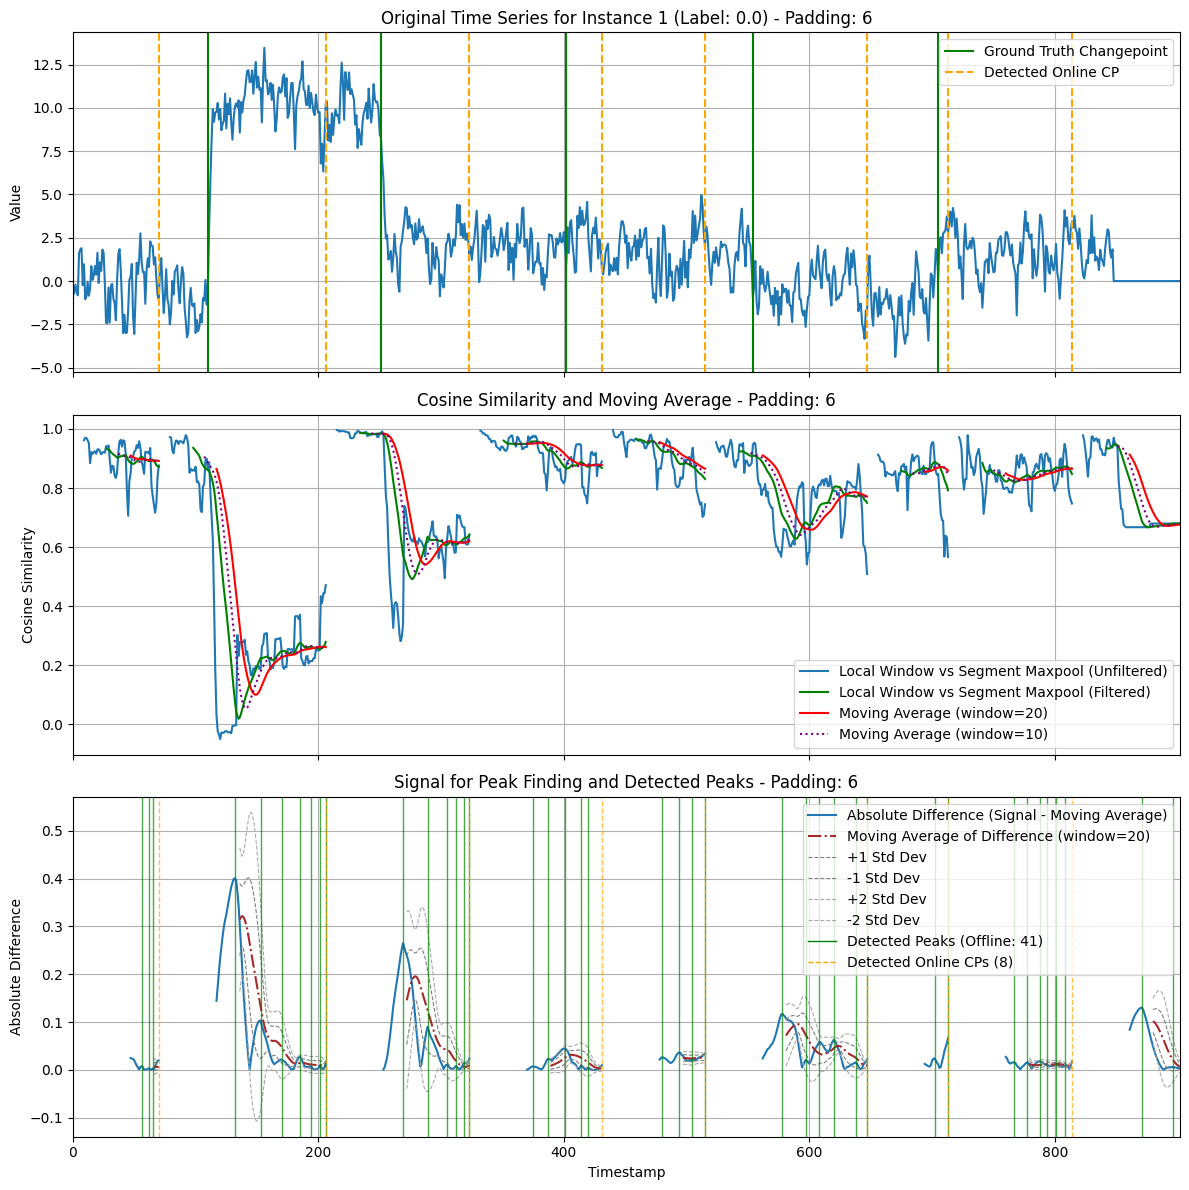

Instance 1 Evaluation (Padding: 6): TP=0, FP=8, FN=5, Precision=0.00, Recall=0.00, F1=0.00
Changepoint detected at timestamp 121 for instance 2
Changepoint detected at timestamp 244 for instance 2
Changepoint detected at timestamp 339 for instance 2
Changepoint detected at timestamp 412 for instance 2
Changepoint detected at timestamp 504 for instance 2
Changepoint detected at timestamp 575 for instance 2
Changepoint detected at timestamp 690 for instance 2
Changepoint detected at timestamp 812 for instance 2


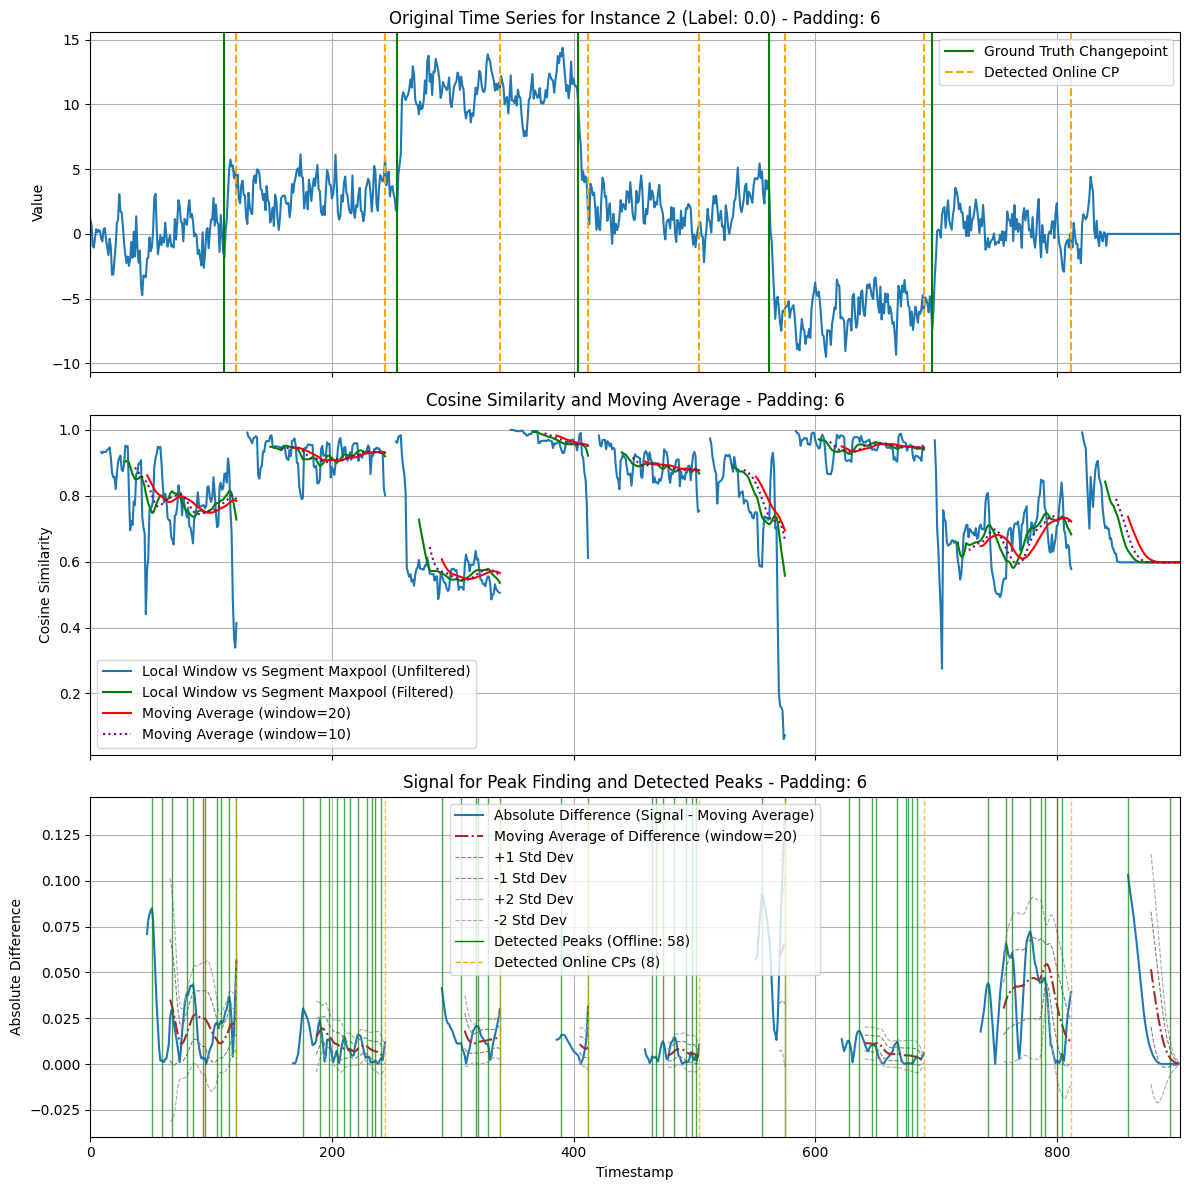

Instance 2 Evaluation (Padding: 6): TP=0, FP=8, FN=5, Precision=0.00, Recall=0.00, F1=0.00
Changepoint detected at timestamp 96 for instance 3
Changepoint detected at timestamp 223 for instance 3
Changepoint detected at timestamp 313 for instance 3
Changepoint detected at timestamp 390 for instance 3
Changepoint detected at timestamp 467 for instance 3
Changepoint detected at timestamp 541 for instance 3
Changepoint detected at timestamp 646 for instance 3
Changepoint detected at timestamp 722 for instance 3
Changepoint detected at timestamp 795 for instance 3
Changepoint detected at timestamp 880 for instance 3


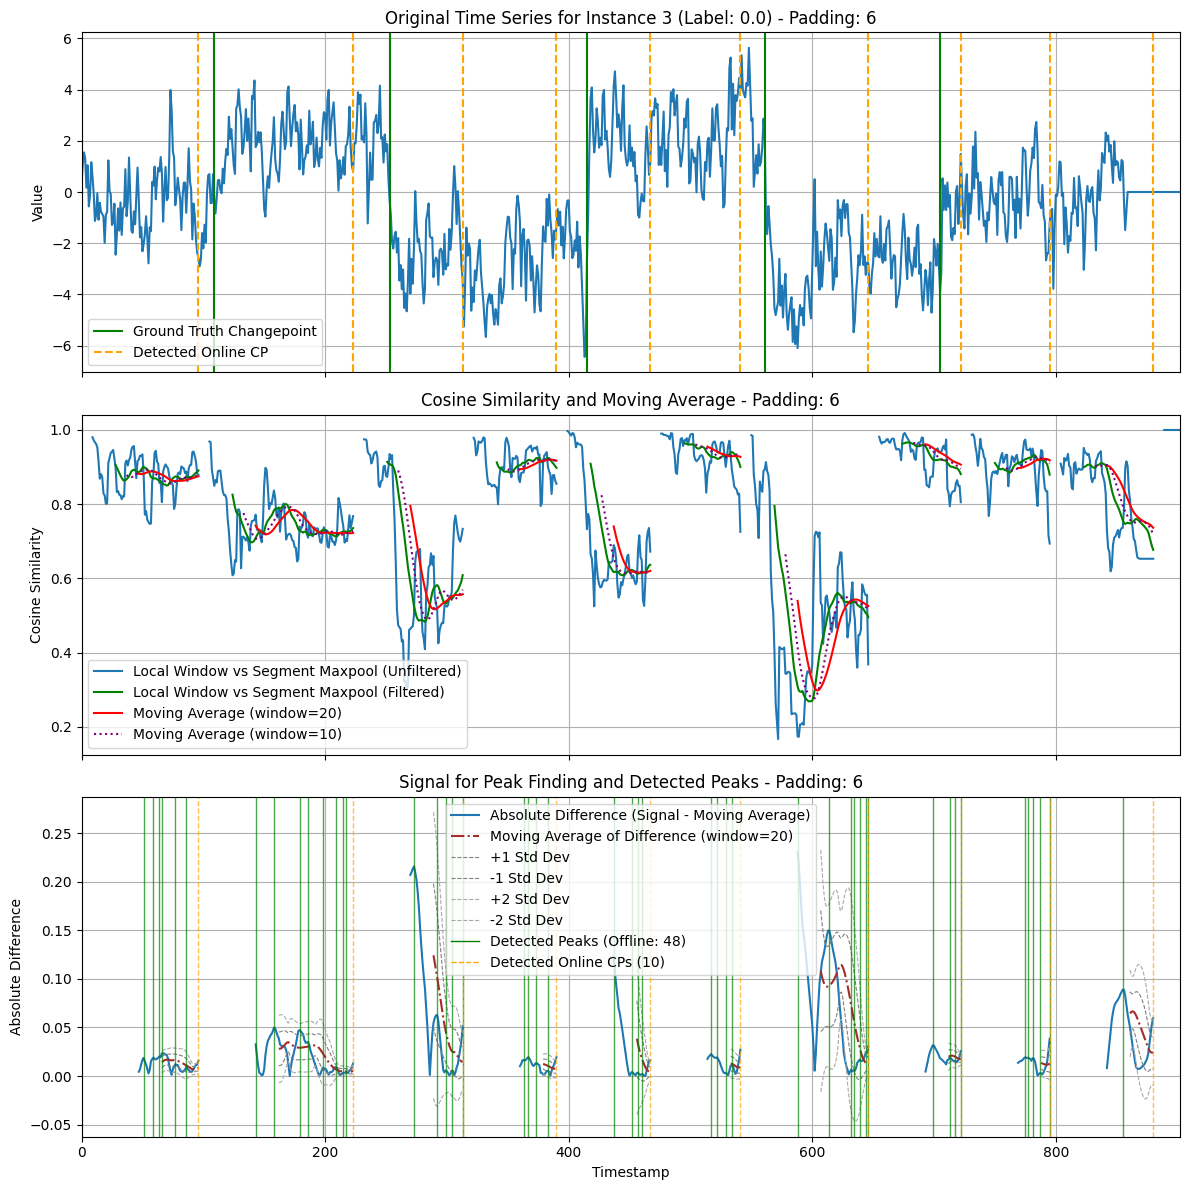

Instance 3 Evaluation (Padding: 6): TP=0, FP=10, FN=5, Precision=0.00, Recall=0.00, F1=0.00
Changepoint detected at timestamp 108 for instance 4
Changepoint detected at timestamp 209 for instance 4
Changepoint detected at timestamp 359 for instance 4
Changepoint detected at timestamp 468 for instance 4
Changepoint detected at timestamp 569 for instance 4
Changepoint detected at timestamp 658 for instance 4
Changepoint detected at timestamp 733 for instance 4
Changepoint detected at timestamp 822 for instance 4
Changepoint detected at timestamp 888 for instance 4


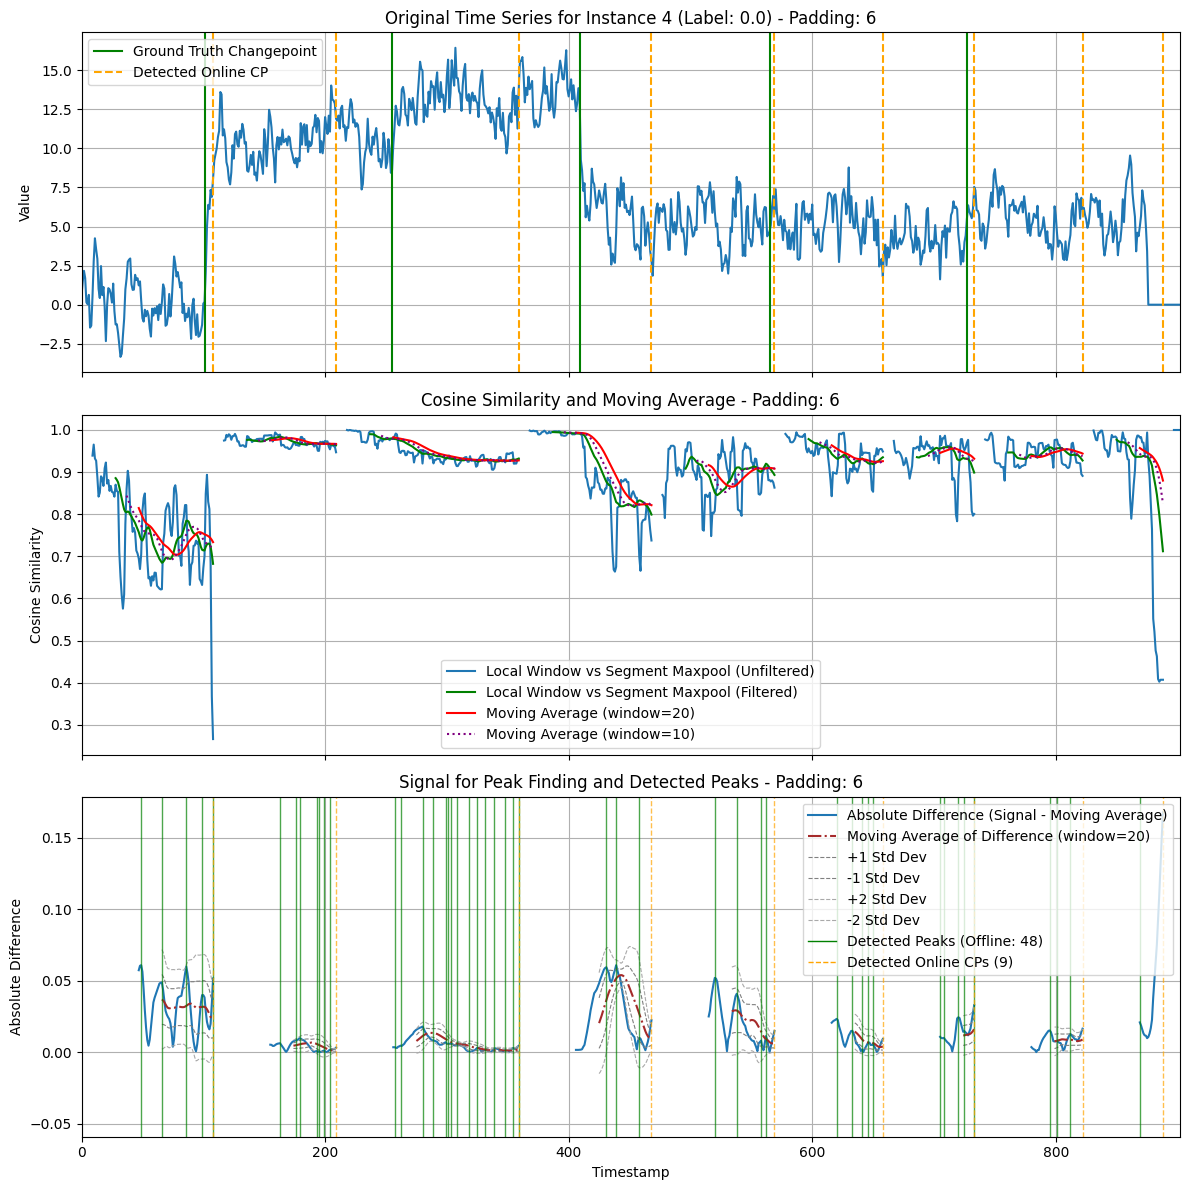

Instance 4 Evaluation (Padding: 6): TP=1, FP=8, FN=4, Precision=0.11, Recall=0.20, F1=0.14
Changepoint detected at timestamp 89 for instance 5
Changepoint detected at timestamp 197 for instance 5
Changepoint detected at timestamp 281 for instance 5
Changepoint detected at timestamp 351 for instance 5
Changepoint detected at timestamp 418 for instance 5
Changepoint detected at timestamp 519 for instance 5
Changepoint detected at timestamp 632 for instance 5
Changepoint detected at timestamp 736 for instance 5
Changepoint detected at timestamp 805 for instance 5


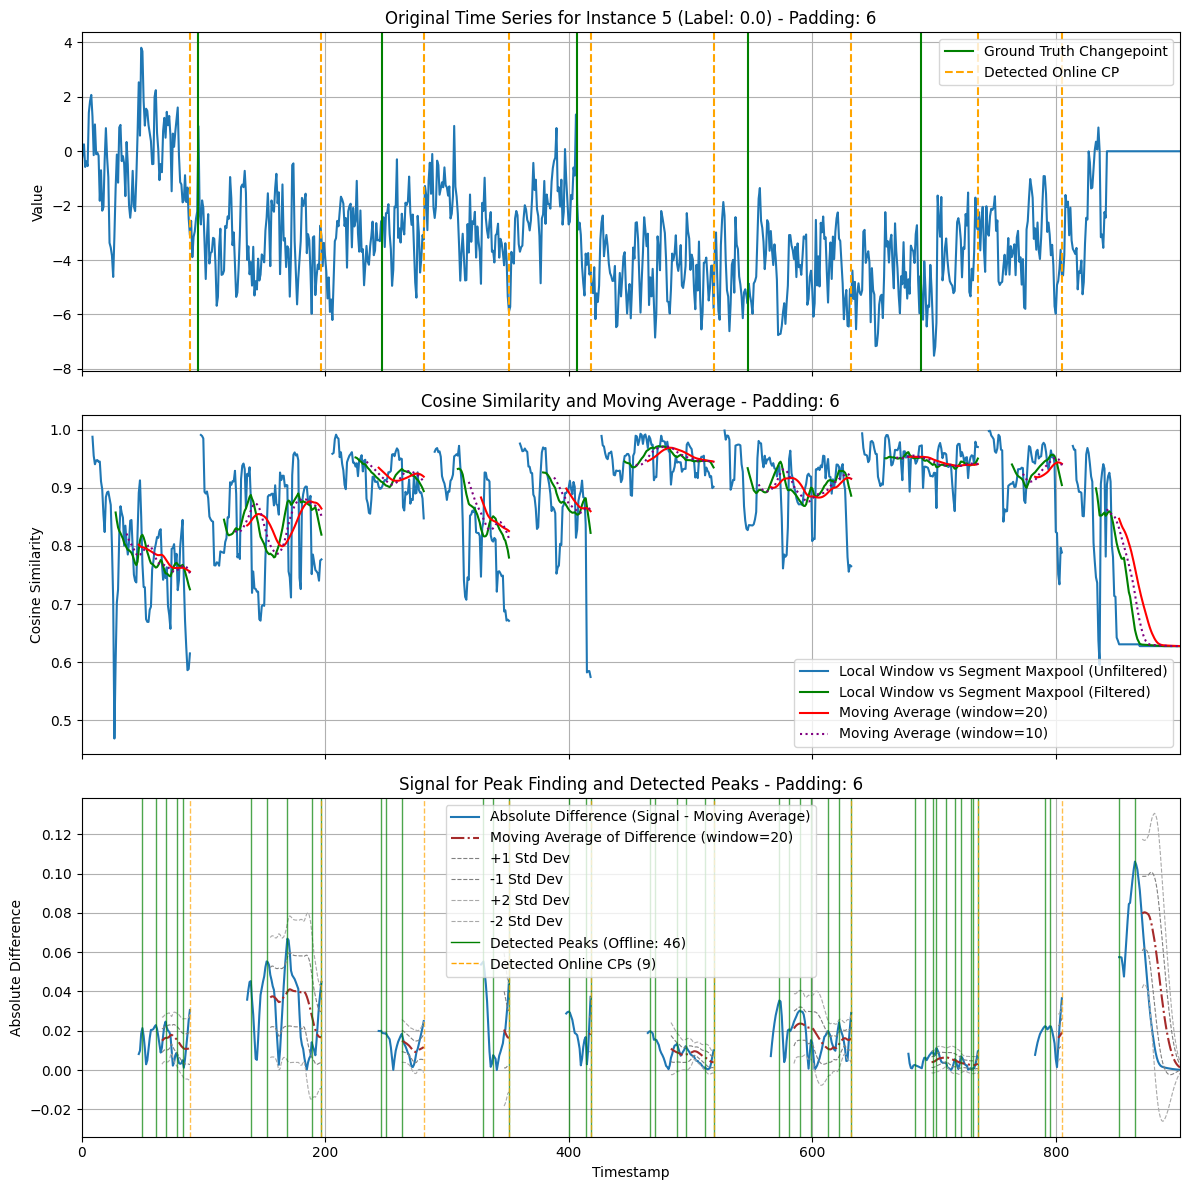

Instance 5 Evaluation (Padding: 6): TP=0, FP=9, FN=5, Precision=0.00, Recall=0.00, F1=0.00

Average Evaluation Metrics for Padding 6:
  Average TP: 0.20
  Average FP: 8.60
  Average FN: 4.80
  Average Precision: 0.02
  Average Recall: 0.04
  Average F1-score: 0.03


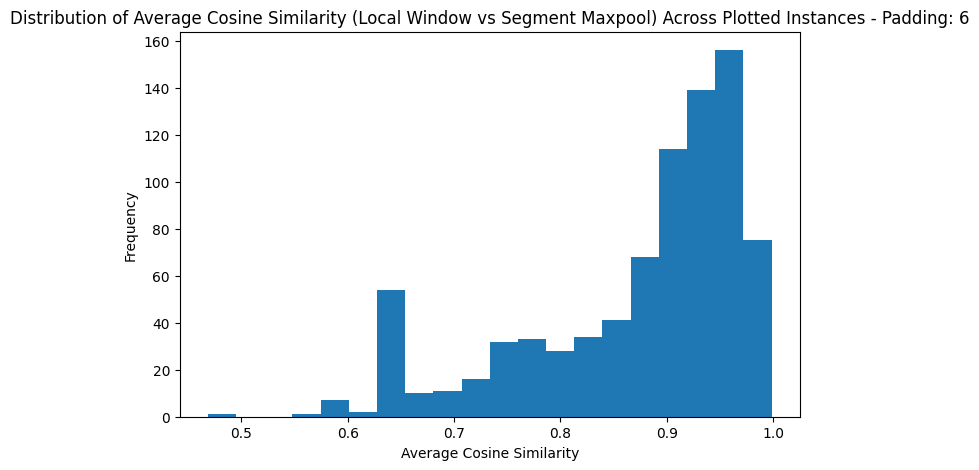


Evaluation Results by Sliding Padding:


{6: {'average_tp': np.float64(0.2),
  'average_fp': np.float64(8.6),
  'average_fn': np.float64(4.8),
  'average_precision': np.float64(0.02222222222222222),
  'average_recall': np.float64(0.04),
  'average_f1_score': np.float64(0.02857142857142857)}}

In [11]:
# Assuming 'model' is your trained TS2Vec model,
# 'test_data' is your test data (np.ndarray),
# and 'test_labels' are your test labels (np.ndarray).

# Replace these with your actual variables
# model = your_ts2vec_model
# test_data = your_test_data
# test_labels = your_test_labels
# ground_truth_cps = your_ground_truth_cps # Optional: provide ground truth CPs if available

# Example parameters (adjust as needed)
sliding_length = 1
sliding_padding = 6
num_instances_to_plot = 5
moving_average_window = 20
pelt_model = "rbf"
pelt_pen = 10
lookback_window = 10
evaluation_tolerance = 5
matched_filter_kernel_size = 20 # Set to 0 or None to disable matched filter
filter_cosine_similarity = True # Set to False to filter the difference signal (if peak_on_difference)
stddev_threshold_multiplier = 2

# Call the componentized analysis function
evaluation_results = run_changepoint_analysis_componentized(
    model=trained_model,
    test_data=test_data_gen,
    test_labels=test_labels_gen,
    sliding_length=sliding_length,
    sliding_padding=sliding_padding,
    num_instances_to_plot=num_instances_to_plot,
    moving_average_window=moving_average_window,
    pelt_model=pelt_model,
    pelt_pen=pelt_pen,
    ground_truth_cps=ground_truth_cps_gen, # Pass ground truth if available
    use_pelt=False, # Set to False to disable PELT plotting
    peak_on_difference=True, # Set to False to plot peaks on similarity
    filter_cosine_similarity=filter_cosine_similarity,
    lookback_window=lookback_window,
    evaluation_tolerance=evaluation_tolerance,
    matched_filter_kernel_size=matched_filter_kernel_size,
    stddev_threshold_multiplier=stddev_threshold_multiplier
)

# Display the evaluation results
print("\nEvaluation Results by Sliding Padding:")
display(evaluation_results)

# Task
Create a new Python function `plot_ts2vec_3d_segments` that takes a trained TS2Vec `model`, `test_data`, `test_labels` (optional), `ground_truth_cps`, and `num_instances` as input. The function should:
1. Select `num_instances` from the `test_data`.
2. For each selected instance, generate its TS2Vec representation using the `model`.
3. Identify the top 3 dimensions in the representation with the highest variance.
4. Create a 3D scatter plot of the representation using these top 3 dimensions.
5. Color the points in the scatter plot based on the segment they belong to, where segments are defined by the `ground_truth_cps`. Points between two changepoints (or from the start to the first changepoint, or from the last changepoint to the end) belong to the same segment.
6. Add appropriate titles and axis labels to the plots.
7. Display the generated plots.

## Define the function signature

### Subtask:
Create a new function `plot_ts2vec_3d_segments` with the specified parameters.


**Reasoning**:
Define the function signature and docstring for the `plot_ts2vec_3d_segments` function as requested by the instructions.



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    pass # Placeholder for function body

**Reasoning**:
Select the specified number of instances from the test data and their corresponding ground truth changepoints and labels if provided.



In [13]:
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

NameError: name 'num_instances' is not defined

**Reasoning**:
The error indicates that the variable `num_instances` is not defined in the current scope. This is because the previous code block only defined the function signature but didn't include the function body where `num_instances` is a parameter. I need to put the instance selection code inside the function definition.



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

## Generate representations

### Subtask:
Inside the function, use the trained model to generate TS2Vec representations for the selected test instances.


**Reasoning**:
Generate TS2Vec representations for the selected instances using the trained model with the specified sliding window parameters.



In [15]:
def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

## Select high-variance dimensions

### Subtask:
For each selected instance, calculate the variance of each dimension in the TS2Vec representations and identify the top 3 dimensions with the highest variance.


**Reasoning**:
Iterate through the representations for each instance, calculate the variance for each dimension, sort the dimensions by variance in descending order, and store the indices of the top 3 dimensions.



In [16]:
def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

    # Calculate variance and identify top 3 dimensions for each instance
    top_3_dims_indices = []
    for i in range(representations.shape[0]):
        instance_repr = representations[i, :, :] # Shape: (n_timestamps, output_dims)

        # Calculate variance for each dimension across time
        variances = np.var(instance_repr, axis=0) # Shape: (output_dims,)

        # Get indices that would sort variances in descending order
        sorted_indices = np.argsort(variances)[::-1]

        # Select the top 3 dimension indices
        top_3_indices = sorted_indices[:3]
        top_3_dims_indices.append(top_3_indices)

        print(f"Instance {i+1}: Top 3 dimension indices by variance: {top_3_indices}")

## Prepare data for plotting

### Subtask:
For each instance, extract the representations of the top 3 dimensions and prepare segment labels based on the ground truth changepoints. Each point in the representation will be assigned a segment index.


**Reasoning**:
Implement the logic to extract the top 3 dimensions and create segment labels for each instance based on the ground truth changepoints.



In [17]:
def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

    # Calculate variance and identify top 3 dimensions for each instance
    top_3_dims_indices = []
    for i in range(representations.shape[0]):
        instance_repr = representations[i, :, :] # Shape: (n_timestamps, output_dims)

        # Calculate variance for each dimension across time
        variances = np.var(instance_repr, axis=0) # Shape: (output_dims,)

        # Get indices that would sort variances in descending order
        sorted_indices = np.argsort(variances)[::-1]

        # Select the top 3 dimension indices
        top_3_indices = sorted_indices[:3]
        top_3_dims_indices.append(top_3_indices)

        print(f"Instance {i+1}: Top 3 dimension indices by variance: {top_3_indices}")

    # Extract top 3 dimensions and create segment labels for each instance
    instance_3d_representations = []
    instance_segment_labels = []

    for i in range(num_instances_to_plot):
        instance_repr = representations[i, :, :]
        top_indices = top_3_dims_indices[i]

        # Extract the representations for the top 3 dimensions
        instance_3d_repr = instance_repr[:, top_indices]
        instance_3d_representations.append(instance_3d_repr)

        # Create segment labels
        n_timestamps = instance_3d_repr.shape[0]
        segment_labels = np.zeros(n_timestamps, dtype=int)

        if selected_cps is not None and i < len(selected_cps):
            current_cps = sorted(selected_cps[i]) # Ensure changepoints are sorted
            current_segment = 0
            last_cp_index = 0
            for t in range(n_timestamps):
                # Check if the current timestamp is a changepoint
                if t in current_cps:
                    current_segment += 1
                    last_cp_index = t # Update the last changepoint index

                # Assign the current segment label to the timestamp
                segment_labels[t] = current_segment
        else:
            # If no ground truth CPs, assign a single segment label (0) to all points
            segment_labels[:] = 0

        instance_segment_labels.append(segment_labels)

        print(f"Instance {i+1}: Shape of 3D representations: {instance_3d_repr.shape}, Shape of segment labels: {segment_labels.shape}")

    # Now instance_3d_representations and instance_segment_labels contain the required data
    # for plotting for each instance.
    # The next steps would involve creating the 3D scatter plots.

## Create 3d plot

### Subtask:
Generate a 3D scatter plot for each selected instance using the top 3 dimensions.


**Reasoning**:
Iterate through the prepared 3D representations and segment labels for each instance and create a 3D scatter plot for each instance using the top 3 dimensions, coloring points by segment label.



In [18]:
def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

    # Calculate variance and identify top 3 dimensions for each instance
    top_3_dims_indices = []
    for i in range(representations.shape[0]):
        instance_repr = representations[i, :, :] # Shape: (n_timestamps, output_dims)

        # Calculate variance for each dimension across time
        variances = np.var(instance_repr, axis=0) # Shape: (output_dims,)

        # Get indices that would sort variances in descending order
        sorted_indices = np.argsort(variances)[::-1]

        # Select the top 3 dimension indices
        top_3_indices = sorted_indices[:3]
        top_3_dims_indices.append(top_3_indices)

        print(f"Instance {i+1}: Top 3 dimension indices by variance: {top_3_indices}")

    # Extract top 3 dimensions and create segment labels for each instance
    instance_3d_representations = []
    instance_segment_labels = []

    for i in range(num_instances_to_plot):
        instance_repr = representations[i, :, :]
        top_indices = top_3_dims_indices[i]

        # Extract the representations for the top 3 dimensions
        instance_3d_repr = instance_repr[:, top_indices]
        instance_3d_representations.append(instance_3d_repr)

        # Create segment labels
        n_timestamps = instance_3d_repr.shape[0]
        segment_labels = np.zeros(n_timestamps, dtype=int)

        if selected_cps is not None and i < len(selected_cps):
            current_cps = sorted(selected_cps[i]) # Ensure changepoints are sorted
            current_segment = 0
            last_cp_index = 0
            for t in range(n_timestamps):
                # Check if the current timestamp is a changepoint
                if t in current_cps:
                    current_segment += 1
                    last_cp_index = t # Update the last changepoint index

                # Assign the current segment label to the timestamp
                segment_labels[t] = current_segment
        else:
            # If no ground truth CPs, assign a single segment label (0) to all points
            segment_labels[:] = 0

        instance_segment_labels.append(segment_labels)

        print(f"Instance {i+1}: Shape of 3D representations: {instance_3d_repr.shape}, Shape of segment labels: {segment_labels.shape}")

    # Generate 3D scatter plots for each instance
    for i in range(num_instances_to_plot):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        instance_3d_repr = instance_3d_representations[i]
        segment_labels = instance_segment_labels[i]

        # Determine the number of unique segments for coloring
        num_segments = np.max(segment_labels) + 1 if len(segment_labels) > 0 else 1

        # Choose a colormap - ensure it has enough colors
        cmap = plt.get_cmap('tab10', max(10, num_segments)) # Use tab10, ensure at least num_segments colors

        # Create the 3D scatter plot
        scatter = ax.scatter(
            instance_3d_repr[:, 0],
            instance_3d_repr[:, 1],
            instance_3d_repr[:, 2],
            c=segment_labels, # Color by segment label
            cmap=cmap,
            marker='o'
        )

        # Add a color bar to show the segment mapping
        cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Segment')

        # Add titles and labels
        instance_title = f'Instance {i+1}'
        if selected_labels is not None and i < len(selected_labels):
             instance_title += f' (Label: {selected_labels[i]})'
        ax.set_title(f'3D TS2Vec Representation by Segment - {instance_title}')
        ax.set_xlabel(f'Dimension {top_3_dims_indices[i][0]}')
        ax.set_ylabel(f'Dimension {top_3_dims_indices[i][1]}')
        ax.set_zlabel(f'Dimension {top_3_dims_indices[i][2]}')

        plt.show()

## Color points by segment

### Subtask:
Color the points in the scatter plot based on the segment they belong to, using a colormap to distinguish between segments.


## Add plot details

### Subtask:
Add appropriate titles and axis labels to the plots.


**Reasoning**:
Add appropriate titles and axis labels to the plots as specified in the subtask instructions.



In [19]:
def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

    # Calculate variance and identify top 3 dimensions for each instance
    top_3_dims_indices = []
    for i in range(representations.shape[0]):
        instance_repr = representations[i, :, :] # Shape: (n_timestamps, output_dims)

        # Calculate variance for each dimension across time
        variances = np.var(instance_repr, axis=0) # Shape: (output_dims,)

        # Get indices that would sort variances in descending order
        sorted_indices = np.argsort(variances)[::-1]

        # Select the top 3 dimension indices
        top_3_indices = sorted_indices[:3]
        top_3_dims_indices.append(top_3_indices)

        print(f"Instance {i+1}: Top 3 dimension indices by variance: {top_3_indices}")

    # Extract top 3 dimensions and create segment labels for each instance
    instance_3d_representations = []
    instance_segment_labels = []

    for i in range(num_instances_to_plot):
        instance_repr = representations[i, :, :]
        top_indices = top_3_dims_indices[i]

        # Extract the representations for the top 3 dimensions
        instance_3d_repr = instance_repr[:, top_indices]
        instance_3d_representations.append(instance_3d_repr)

        # Create segment labels
        n_timestamps = instance_3d_repr.shape[0]
        segment_labels = np.zeros(n_timestamps, dtype=int)

        if selected_cps is not None and i < len(selected_cps):
            current_cps = sorted(selected_cps[i]) # Ensure changepoints are sorted
            current_segment = 0
            last_cp_index = 0
            for t in range(n_timestamps):
                # Check if the current timestamp is a changepoint
                if t in current_cps:
                    current_segment += 1
                    last_cp_index = t # Update the last changepoint index

                # Assign the current segment label to the timestamp
                segment_labels[t] = current_segment
        else:
            # If no ground truth CPs, assign a single segment label (0) to all points
            segment_labels[:] = 0

        instance_segment_labels.append(segment_labels)

        print(f"Instance {i+1}: Shape of 3D representations: {instance_3d_repr.shape}, Shape of segment labels: {segment_labels.shape}")

    # Generate 3D scatter plots for each instance
    for i in range(num_instances_to_plot):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        instance_3d_repr = instance_3d_representations[i]
        segment_labels = instance_segment_labels[i]

        # Determine the number of unique segments for coloring
        num_segments = np.max(segment_labels) + 1 if len(segment_labels) > 0 else 1

        # Choose a colormap - ensure it has enough colors
        cmap = plt.get_cmap('tab10', max(10, num_segments)) # Use tab10, ensure at least num_segments colors

        # Create the 3D scatter plot
        scatter = ax.scatter(
            instance_3d_repr[:, 0],
            instance_3d_repr[:, 1],
            instance_3d_repr[:, 2],
            c=segment_labels, # Color by segment label
            cmap=cmap,
            marker='o'
        )

        # Add a color bar to show the segment mapping
        cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Segment') # Label the color bar

        # Add titles and labels
        instance_title = f'Instance {i+1}'
        if selected_labels is not None and i < len(selected_labels):
             instance_title += f' (Label: {selected_labels[i]})'
        ax.set_title(f'3D TS2Vec Representation by Segment - {instance_title}') # Set the title
        ax.set_xlabel(f'Dimension {top_3_dims_indices[i][0]}') # Set x-axis label
        ax.set_ylabel(f'Dimension {top_3_dims_indices[i][1]}') # Set y-axis label
        ax.set_zlabel(f'Dimension {top_3_dims_indices[i][2]}') # Set z-axis label

        plt.show()

## Display the plots

### Subtask:
Display the generated 3D plots.


**Reasoning**:
The previous steps have prepared the data and created the plot elements. The final step is to display the generated plots using `plt.show()`.



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ts2vec_3d_segments(model, test_data, test_labels=None, ground_truth_cps=None, num_instances=1):
    """
    Generates 3D scatter plots of TS2Vec representations, colored by segments defined by changepoints,
    and displays the original time series with colored segments and changepoints alongside.

    Args:
        model (TS2Vec): Trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray, optional): Test labels. Defaults to None.
        ground_truth_cps (list, optional): Ground truth changepoint locations (list of lists). Defaults to None.
        num_instances (int, optional): Number of test instances to plot. Defaults to 1.
    """
    # Select instances to plot
    num_instances_to_plot = min(num_instances, test_data.shape[0])
    selected_data = test_data[:num_instances_to_plot]
    selected_labels = test_labels[:num_instances_to_plot] if test_labels is not None else None
    selected_cps = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Generate TS2Vec representations
    # Use causal=True, sliding_length=1, and sliding_padding=6 as specified
    representations = model.encode(
        selected_data,
        causal=True,
        sliding_length=1,
        sliding_padding=6
    )
    print(f"Shape of generated representations: {representations.shape}")

    # Calculate variance and identify top 3 dimensions for each instance
    top_3_dims_indices = []
    for i in range(representations.shape[0]):
        instance_repr = representations[i, :, :] # Shape: (n_timestamps, output_dims)

        # Calculate variance for each dimension across time
        variances = np.var(instance_repr, axis=0) # Shape: (output_dims,)

        # Get indices that would sort variances in descending order
        sorted_indices = np.argsort(variances)[::-1]

        # Select the top 3 dimension indices
        top_3_indices = sorted_indices[:3]
        top_3_dims_indices.append(top_3_indices)

        print(f"Instance {i+1}: Top 3 dimension indices by variance: {top_3_indices}")

    # Extract top 3 dimensions and create segment labels for each instance
    instance_3d_representations = []
    instance_segment_labels = []

    for i in range(num_instances_to_plot):
        instance_repr = representations[i, :, :]
        top_indices = top_3_dims_indices[i]

        # Extract the representations for the top 3 dimensions
        instance_3d_repr = instance_repr[:, top_indices]
        instance_3d_representations.append(instance_3d_repr)

        # Create segment labels
        n_timestamps = instance_3d_repr.shape[0]
        segment_labels = np.zeros(n_timestamps, dtype=int)

        if selected_cps is not None and i < len(selected_cps):
            current_cps = sorted(selected_cps[i]) # Ensure changepoints are sorted
            current_segment = 0
            last_cp_index = 0
            for t in range(n_timestamps):
                # Check if the current timestamp is a changepoint
                if t in current_cps:
                    current_segment += 1
                    last_cp_index = t # Update the last changepoint index

                # Assign the current segment label to the timestamp
                segment_labels[t] = current_segment
        else:
            # If no ground truth CPs, assign a single segment label (0) to all points
            segment_labels[:] = 0

        instance_segment_labels.append(segment_labels)

        print(f"Instance {i+1}: Shape of 3D representations: {instance_3d_repr.shape}, Shape of segment labels: {segment_labels.shape}")

    # Generate plots for each instance
    for i in range(num_instances_to_plot):
        fig = plt.figure(figsize=(15, 8)) # Adjust figure size for two subplots

        # Subplot 1: Original Time Series with Changepoints and Colored Segments
        ax1 = fig.add_subplot(1, 2, 1) # 1 row, 2 columns, 1st plot

        original_data = selected_data[i, :, 0] # Assuming 1 feature for simplicity
        segment_labels = instance_segment_labels[i] # Get the segment labels for this instance

        # Determine the number of unique segments for coloring
        num_segments = np.max(segment_labels) + 1 if len(segment_labels) > 0 else 1

        # Choose a colormap - ensure it has enough colors and matches the 3D plot
        cmap = plt.get_cmap('tab10', max(10, num_segments)) # Use tab10, ensure at least num_segments colors

        # Plot the original time series, coloring points by segment
        for segment in range(num_segments):
            segment_indices = np.where(segment_labels == segment)[0]
            if len(segment_indices) > 0:
                # Plot segments as continuous lines for better visualization
                start_idx = segment_indices[0]
                end_idx = segment_indices[-1] + 1 # Include the last point of the segment

                # Find contiguous blocks within the segment indices
                # This handles cases where a segment might be split due to padding or other reasons
                # Although with the current segment labeling logic, segments should be contiguous.
                # Still, this approach is more robust.
                diffs = np.diff(segment_indices)
                split_points = np.where(diffs > 1)[0] + 1
                contiguous_blocks = np.split(segment_indices, split_points)

                for block_indices in contiguous_blocks:
                     if len(block_indices) > 0:
                          ax1.plot(
                              block_indices,
                              original_data[block_indices],
                              color=cmap(segment), # Use the same color as the 3D plot
                              label=f'Segment {segment}' if block_indices[0] == start_idx else "" # Label only the first block
                          )


        ax1.set_title(f'Original Time Series - Instance {i+1}')
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel('Value')
        ax1.grid(True)

        # Add vertical lines for ground truth changepoints
        if selected_cps is not None and i < len(selected_cps):
            for gt_cp in selected_cps[i]:
                if gt_cp < original_data.shape[0]:
                    ax1.axvline(x=gt_cp, color='black', linestyle='--', lw=1.5, label='Ground Truth CP' if gt_cp == selected_cps[i][0] else "") # Use a distinct color like black for CPs
        # Add a dummy plot for the scatter legend handle if needed
        # ax1.plot([], [], 'o', color=cmap(0), label='Segment') # Example for segment legend if needed

        # Combine and show legends
        handles, labels = ax1.get_legend_handles_labels()
        # Remove duplicate labels if any
        unique_labels = dict(zip(labels, handles))
        ax1.legend(unique_labels.values(), unique_labels.keys())


        # Subplot 2: 3D TS2Vec Representation
        ax2 = fig.add_subplot(1, 2, 2, projection='3d') # 1 row, 2 columns, 2nd plot

        instance_3d_repr = instance_3d_representations[i]
        # segment_labels is already defined for this instance

        # Determine the number of unique segments for coloring (already done for ax1)
        # num_segments = np.max(segment_labels) + 1 if len(segment_labels) > 0 else 1

        # Choose a colormap - ensure it has enough colors and matches the 3D plot (already done for ax1)
        # cmap = plt.get_cmap('tab10', max(10, num_segments))

        # Create the 3D scatter plot
        scatter = ax2.scatter(
            instance_3d_repr[:, 0],
            instance_3d_repr[:, 1],
            instance_3d_repr[:, 2],
            c=segment_labels, # Color by segment label
            cmap=cmap, # Use the same colormap
            marker='o'
        )

        # Add a color bar to show the segment mapping
        cbar = fig.colorbar(scatter, ax=ax2, pad=0.1)
        cbar.set_label('Segment') # Label the color bar

        # Add titles and labels
        instance_title = f'Instance {i+1}'
        if selected_labels is not None and i < len(selected_labels):
             instance_title += f' (Label: {selected_labels[i]})'
        ax2.set_title(f'3D TS2Vec Representation by Segment - {instance_title}') # Set the title
        ax2.set_xlabel(f'Dimension {top_3_dims_indices[i][0]}') # Set x-axis label
        ax2.set_ylabel(f'Dimension {top_3_dims_indices[i][1]}') # Set y-axis label
        ax2.set_zlabel(f'Dimension {top_3_dims_indices[i][2]}') # Set z-axis label

        plt.tight_layout() # Adjust layout to prevent overlapping
        plt.show() # Display the plot

## Summary:

### Data Analysis Key Findings

*   The function successfully selects the specified number of test instances (`num_instances`) from the input data.
*   TS2Vec representations are generated for the selected instances using the model with `causal=True`, `sliding_length=1`, and `sliding_padding=6`. The shape of the representations is `(n_instances_to_plot, n_timestamps, output_dims)`.
*   For each instance, the variance is calculated across the time dimension for each output dimension of the TS2Vec representation.
*   The indices of the top 3 dimensions with the highest variance are identified for each instance.
*   3D representations are extracted by selecting the data corresponding to the top 3 dimensions, resulting in arrays of shape `(n_timestamps, 3)` for each instance.
*   Segment labels are created for each timestamp based on the `ground_truth_cps`. Timestamps between two changepoints (or from the start to the first, or from the last to the end) are assigned the same segment index. If no changepoints are provided for an instance, all timestamps are assigned to segment 0.
*   For each selected instance, a 3D scatter plot is generated using the extracted 3D representations, where points are colored according to their assigned segment labels using a colormap.
*   Titles (including instance number and label if available), axis labels (indicating the index of the plotted dimension), and a color bar (labeled 'Segment') are added to each plot.
*   Each generated plot is displayed.

### Insights or Next Steps

*   The visualization effectively shows how the TS2Vec representation of a time series evolves in a 3D space, colored by ground truth segments, which can be useful for understanding if the representation captures structural changes in the data.
*   Further analysis could involve visualizing the representations using dimensionality reduction techniques like t-SNE or UMAP for a potentially better separation of segments in lower-dimensional space, especially if the top 3 variance dimensions do not clearly separate segments.


Shape of generated representations: (3, 903, 320)
Instance 1: Top 3 dimension indices by variance: [118 216 180]
Instance 2: Top 3 dimension indices by variance: [216 118 180]
Instance 3: Top 3 dimension indices by variance: [80 63 60]
Instance 1: Shape of 3D representations: (903, 3), Shape of segment labels: (903,)
Instance 2: Shape of 3D representations: (903, 3), Shape of segment labels: (903,)
Instance 3: Shape of 3D representations: (903, 3), Shape of segment labels: (903,)


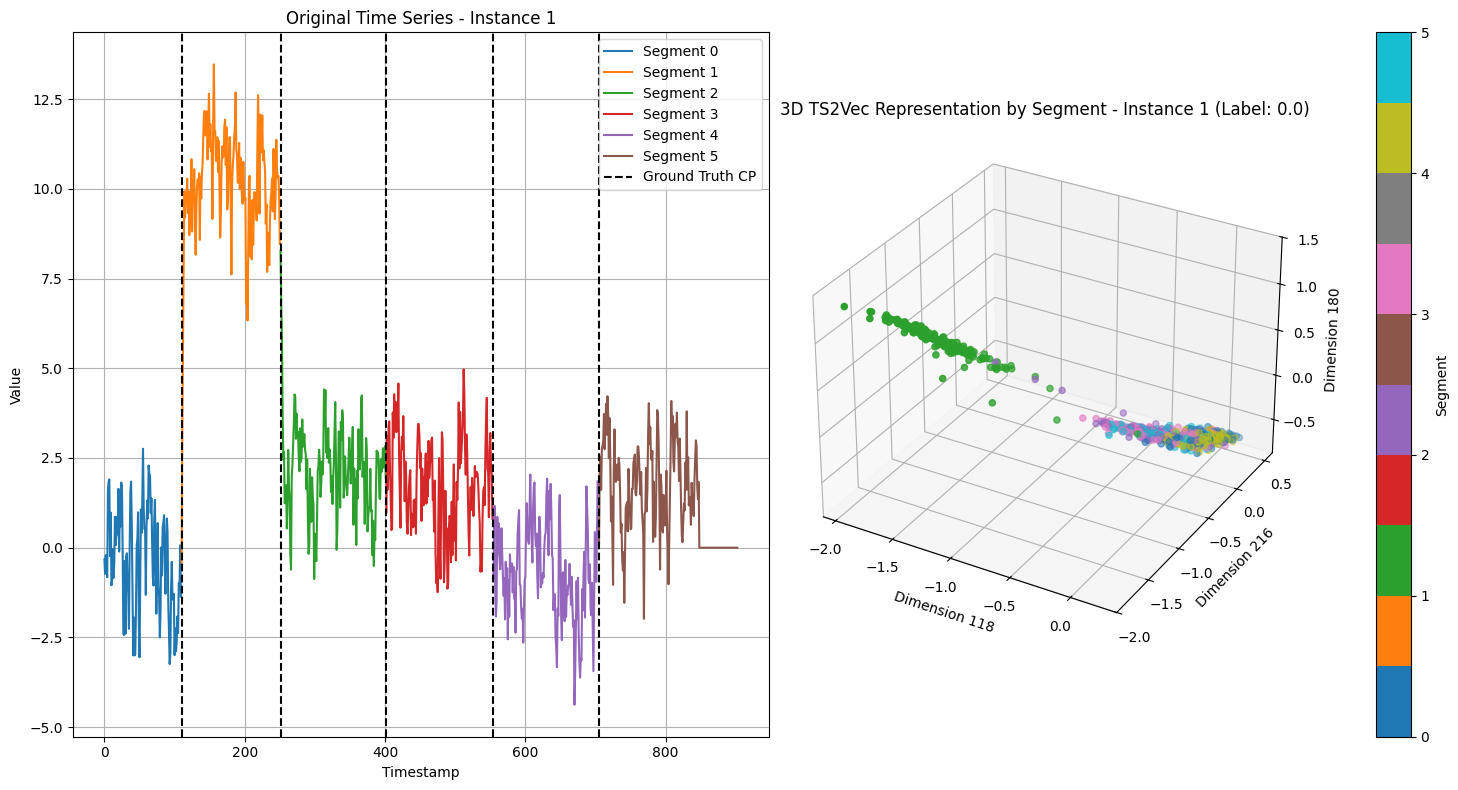

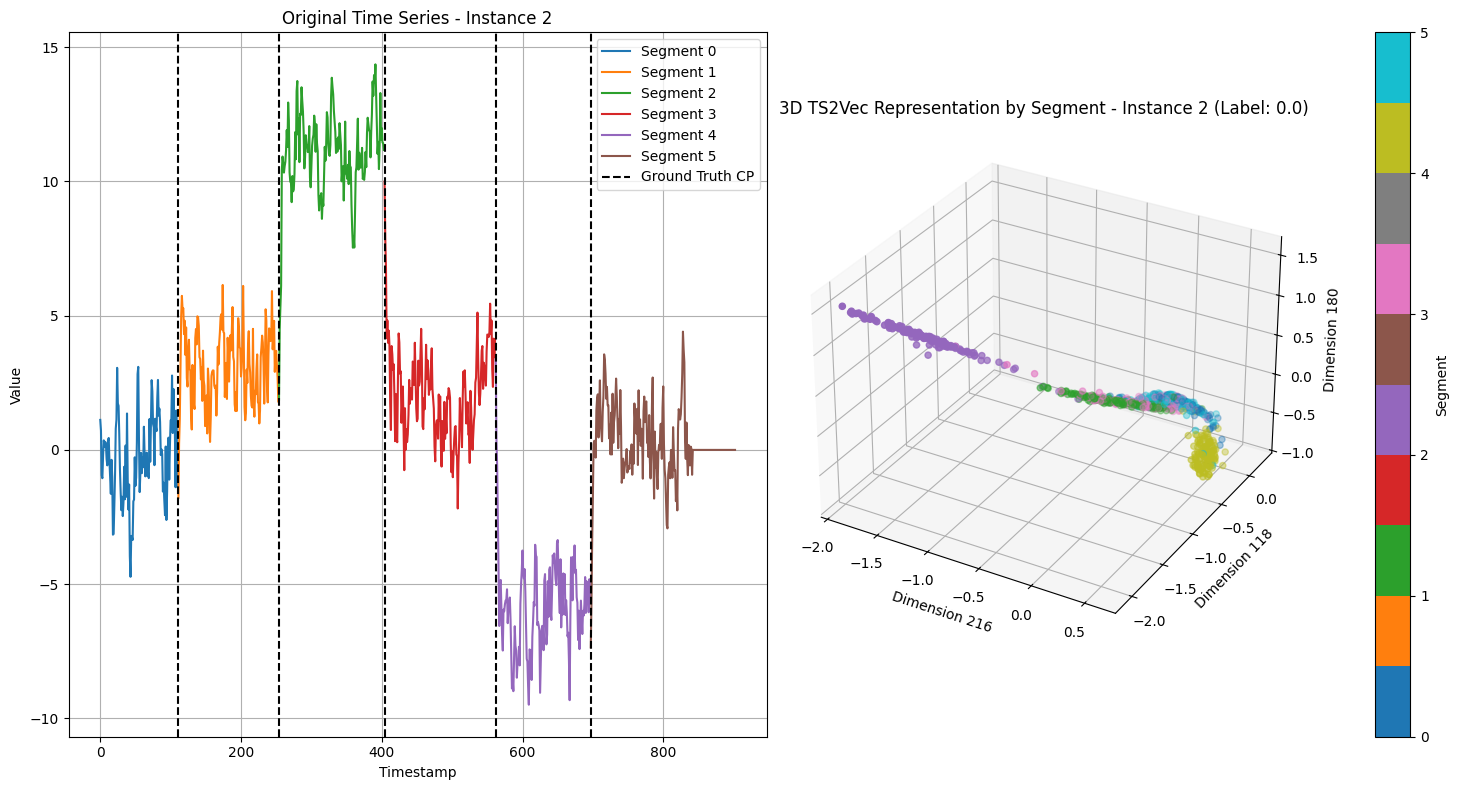

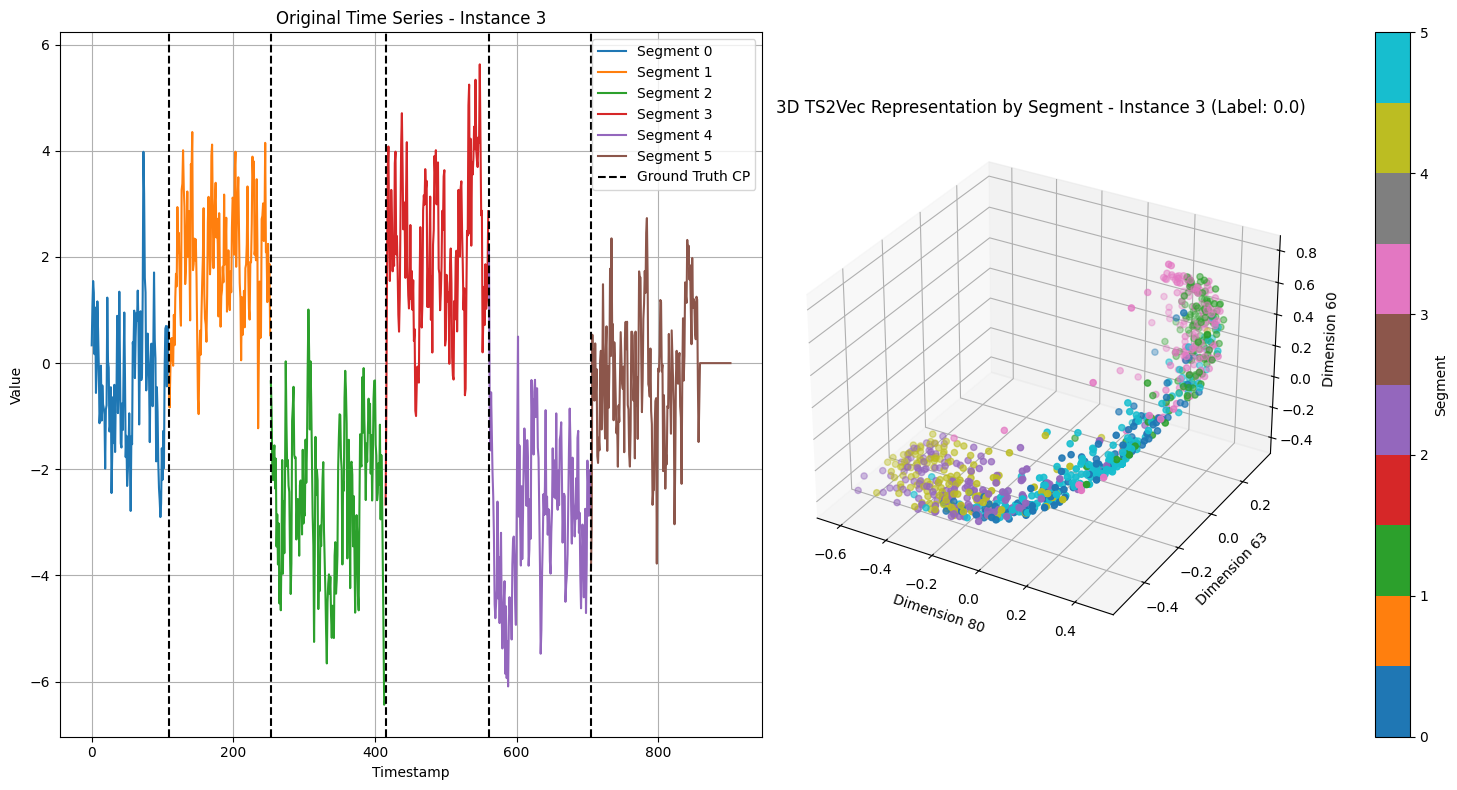

In [25]:
# Call the plotting function with the trained model and generated data
plot_ts2vec_3d_segments(
    model=trained_model,
    test_data=test_data_gen,
    test_labels=test_labels_gen,  # Pass labels if you want them in the title
    ground_truth_cps=ground_truth_cps_gen,
    num_instances=3  # Specify the number of instances to plot
)